# Gauge transformation of the gauge links in a LC coordinate lattice

## Step 0

### Writting the fields from files

In [1]:
import os

os.environ["MY_NUMBA_TARGET"] = "numba"
os.environ["PRECISION"] = "double"
os.environ['GAUGE_GROUP'] = 'su3'

# Import relevant modules
import sys
sys.path.append('..')

import curraun.su as su
import numpy as np
import pickle

Using SU(3)
Using Numba
Using double precision


In [2]:
# I need to add this line to ask resources from a specific GPU, which is free. Our GPU server has no queing system
os.environ["CUDA_VISIBLE_DEVICES"]="3"

In [3]:
# We read the fields

fields = np.load('gauge_links_fields_glasma_test.npz')
ux = fields['ux']; aeta = fields['aeta']

with open('parameters_gauge_transf_glasma_test.pickle', 'rb') as f:
    param = pickle.load(f)

In [4]:
print(np.shape(ux))
print(np.shape(aeta))

(64, 16384, 9)
(64, 16384, 9)


In [5]:
# We get the relevant parameters

N = param['N']
Dg = param['DG']
L = param['L']
Qs = param['QS']

t_steps = np.shape(ux)[0]

a = L/N
g = np.pi * np.sqrt(1 / np.log(Qs / 0.2))

In [6]:
# We reshape the transverse component into a N*N matrix

ux_r = ux.reshape((t_steps, N, N, Dg))
aeta_r = aeta.reshape((t_steps, N, N, Dg))

print(np.shape(ux_r))
print(np.shape(aeta_r))

(64, 128, 128, 9)
(64, 128, 128, 9)


## Step 1

In [7]:
# Supress various horribly long warnings
import warnings
warnings.filterwarnings('ignore')

### We write the relevant magnitude in LC coordinates

In [8]:
# We construct the z links from Aeta

uz = su.GROUP_TYPE([[[[su.mexp(su.mul_s(aeta_r[t,x,y], 1j*g*a*(z-N//2))) for z in range(N)] for y in range(N)] for x in range(N)] for t in range(t_steps)])

In [ ]:
uz_test = uz.reshape(t_steps, N, N, N, 3, 3)
print(uz_test[t_steps//2, N//2, N//2, 0, :, :])

[[15.23139035-3.13020387e-15j  9.91365669-1.80581101e+00j
   2.70348908-9.12942161e+00j]
 [ 9.91365669+1.80581101e+00j  6.87114893+6.37258503e-16j
   2.59251031-5.48640699e+00j]
 [ 2.70348908+9.12942161e+00j  2.59251031+5.48640699e+00j
   6.66638882+2.17145878e-15j]]


In [ ]:
# We define a function that, given a set of gauge links, returns the values over the x^+ axis

def get_LC_links (u_x):
    uminus = su.GROUP_TYPE([[[[su.mul(uz[t,x,y,z],u_x[t,x,y]) for z in range(N)] for y in range(N)] for x in range(N)] for t in range(t_steps)])
    uplus = su.GROUP_TYPE([[[[su.mul(uz[t,x,y,z],su.GROUP_TYPE(su.dagger(u_x[t,x,y]))) for z in range(N)] for y in range(N)] for x in range(N)] for t in range(t_steps)])
    return uplus, uminus

In [ ]:
u_plus_temp, u_minus_temp = get_LC_links(ux_r)

print(np.shape(u_plus_temp))
print(np.shape(u_minus_temp))

/home2/carlos.lamas/condacurraun/lib/python3.10/site-packages/numba/core/typed_passes.py:329: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.readthedocs.io/en/stable/user/parallel.html#diagnostics for help.

File "../curraun/su3.py", line 119:
@myjit
def mul(a, b):
^

  warnings.warn(errors.NumbaPerformanceWarning(msg,
/home2/carlos.lamas/condacurraun/lib/python3.10/site-packages/numba/core/typed_passes.py:329: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.readthedocs.io/en/stable/user/parallel.html#diagnostics for help.

File "../curraun/su3.py", line 416:
@myjit
def dagger(a):
^

  warnings.warn(errors.NumbaPerformanceWarning(msg,


In [ ]:
print(u_plus_temp[t_steps//2, N//2, N//2, N//2, :])

[ 0.99766304+0.00598429j -0.05701835+0.03213106j  0.01072109+0.0153036j
  0.05689127+0.032335j    0.99784253-0.00343299j  0.00397506+0.00073196j
 -0.01100067+0.01514778j -0.00384629-0.00046327j  0.99981396-0.00256212j]


## Step 2

### We gauge transform the relevant quantity to LC gauge

In [ ]:
# We construct a function that gives the gauge operator at a given point

def gauge_operator(u, x):
    v = su.GROUP_TYPE([[su.unit() for z in range(N)] for y in range(N)])
    for t in range(x//2):
        buffer = v
        v = su.GROUP_TYPE([[su.mul(u[t,x-t,y,z], buffer[y,z]) for z in range(N)] for y in range(N)])
    return v

In [ ]:
# We construct an array with the gauge operator over the x^+ axis

v_LC = su.GROUP_TYPE(np.zeros((t_steps, N, N, Dg)))
for x in range (N):
    if x%2 == 0:
        v_LC[x//2,:,:,:] = gauge_operator(u_minus_temp, x)

print(np.shape(v_LC))

/home2/carlos.lamas/condacurraun/lib/python3.10/site-packages/numba/core/typed_passes.py:329: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.readthedocs.io/en/stable/user/parallel.html#diagnostics for help.

File "../curraun/su3.py", line 440:
@myjit
def unit():
^

  warnings.warn(errors.NumbaPerformanceWarning(msg,


(64, 128, 128, 9)


In [ ]:
# We construct a function that performs the gauge transformation of the plus link

def act_plus_link (u,v):
    buffer1 = su.GROUP_TYPE([[[su.mul(su.GROUP_TYPE(su.dagger(v[t+1, y, z])), u[t, t, y,z]) for z in range(N)] for y in range(N)] for t in range(t_steps-1)])
    r = su.GROUP_TYPE([[[su.mul(buffer1[t,y,z], v[t,y,z]) for z in range(N)] for y in range(N)] for t in range (t_steps-1)])
    return r

In [ ]:
# We transform the plus link

uplus_LC = act_plus_link(u_plus_temp, v_LC)

print(np.shape(uplus_LC))

(63, 128, 128, 9)


In [ ]:
# We plot U_+ at one point of the axis to have some intuition about its value

uplus_LC_r = uplus_LC.reshape((t_steps-1, N, N, 3, 3))
print(uplus_LC_r[t_steps//2, N//2, N//2, :])

[[ 0.98675732-0.03360514j -0.1039674 +0.02680459j  0.11679902-0.00331073j]
 [ 0.11605198-0.01505914j  0.95867834-0.21079397j -0.07940447+0.12845949j]
 [-0.10646263-0.01231045j  0.08754094+0.13156985j  0.95056108+0.24489541j]]


Close to the identity but not exactly

- - -
We write the $U_+$ gauge link to file

In [ ]:
np.savez_compressed('uplus_lc_gauge_transf.npz', uplus=uplus_LC)

Output $U_-$ in a format that is appropriate to be read in C++.

In [ ]:
np.save('uplus_lc_gauge_transf.npy', uplus_LC)

In [ ]:
np.save('uplus_lc_gauge_transf_time_slice.npy', uplus_LC[0,:,:])

In [ ]:
uplus_LC[10,17,:]

array([[  483.23899082  +35.29614002j,   103.72231235 +402.92047194j,
         -905.94491618 +328.53044308j, ...,
        -1150.62104561 -539.9960488j ,   124.3258352 -1085.76277859j,
         2530.08348345  +45.1517677j ],
       [  423.60666853  +32.93389287j,    86.29899416 +353.5159403j ,
         -797.5353005  +278.74966409j, ...,
        -1013.58940194 -467.37590573j,   109.96745488 -951.06040883j,
         2221.57542579  +40.08563928j],
       [  371.39216146  +30.64321045j,    71.54408279 +310.15529436j,
         -702.13900221 +236.12296619j, ...,
         -892.91773736 -404.33868017j,    97.28836533 -833.0396597j ,
         1950.75533197  +35.6125991j ],
       ...,
       [   11.65210487   +3.09189244j,   -22.41367466  +21.49225837j,
           16.11846664   +7.80620902j, ...,
          117.93349516  +46.23525336j,  -289.14324542 +250.4267971j ,
          182.73881488 +111.11015529j],
       [   12.95542042   +2.79056924j,   -23.07412717  +25.47561879j,
           18.40108937

## Step 3

### We transform $U_-$ to LC gauge as a check

In [ ]:
# We construct a function with the gauge operator at the next x^- step to the x^+ axis

v_LC_plus1 = su.GROUP_TYPE([[[su.mul(u_minus_temp[t,t,y,z], v_LC[t,y,z]) for z in range(N)] for y in range(N)] for t in range(t_steps-1)])

In [ ]:
# We construct a function that performs the gauge transformation of the minus links

def act_minus_links(u, v, aux): #TODO: Writte the function with only u and v as inputs?
    buffer1 = su.GROUP_TYPE([[[su.mul(su.GROUP_TYPE(su.dagger(aux[t, y, z])), u[t, t, y,z]) for z in range(N)] for y in range(N)] for t in range(t_steps-1)])
    r = su.GROUP_TYPE([[[su.mul(buffer1[t,y,z], v[t,y,z]) for z in range(N)] for y in range(N)] for t in range (t_steps-1)])
    return r

In [ ]:
# We transform the minus link

uminus_LC = act_minus_links(u_minus_temp, v_LC, v_LC_plus1)

print(np.shape(uminus_LC))

(63, 128, 128, 9)


In [ ]:
# We plot U_- at one point of the axis to check that it is close to identity

uminus_LC_r = uminus_LC.reshape((t_steps-1, N, N, 3, 3))
print(uminus_LC_r[t_steps//2, N//2, N//2, :, :])

[[ 1.00000000e+00+1.38777878e-17j  2.84494650e-16-4.46864767e-15j
  -6.86950496e-15-9.71106408e-15j]
 [ 3.85108612e-16+4.38538095e-15j  1.00000000e+00+2.77555756e-17j
   1.05471187e-15+3.03421484e-15j]
 [-6.84174939e-15+9.67281810e-15j  1.02695630e-15-3.02535774e-15j
   1.00000000e+00+3.21075414e-18j]]


The gauge links in minus direction are indeed transformed to the identity. Much closer to 1 that $U_+$ links

# Step 4

### We plot the transformed links

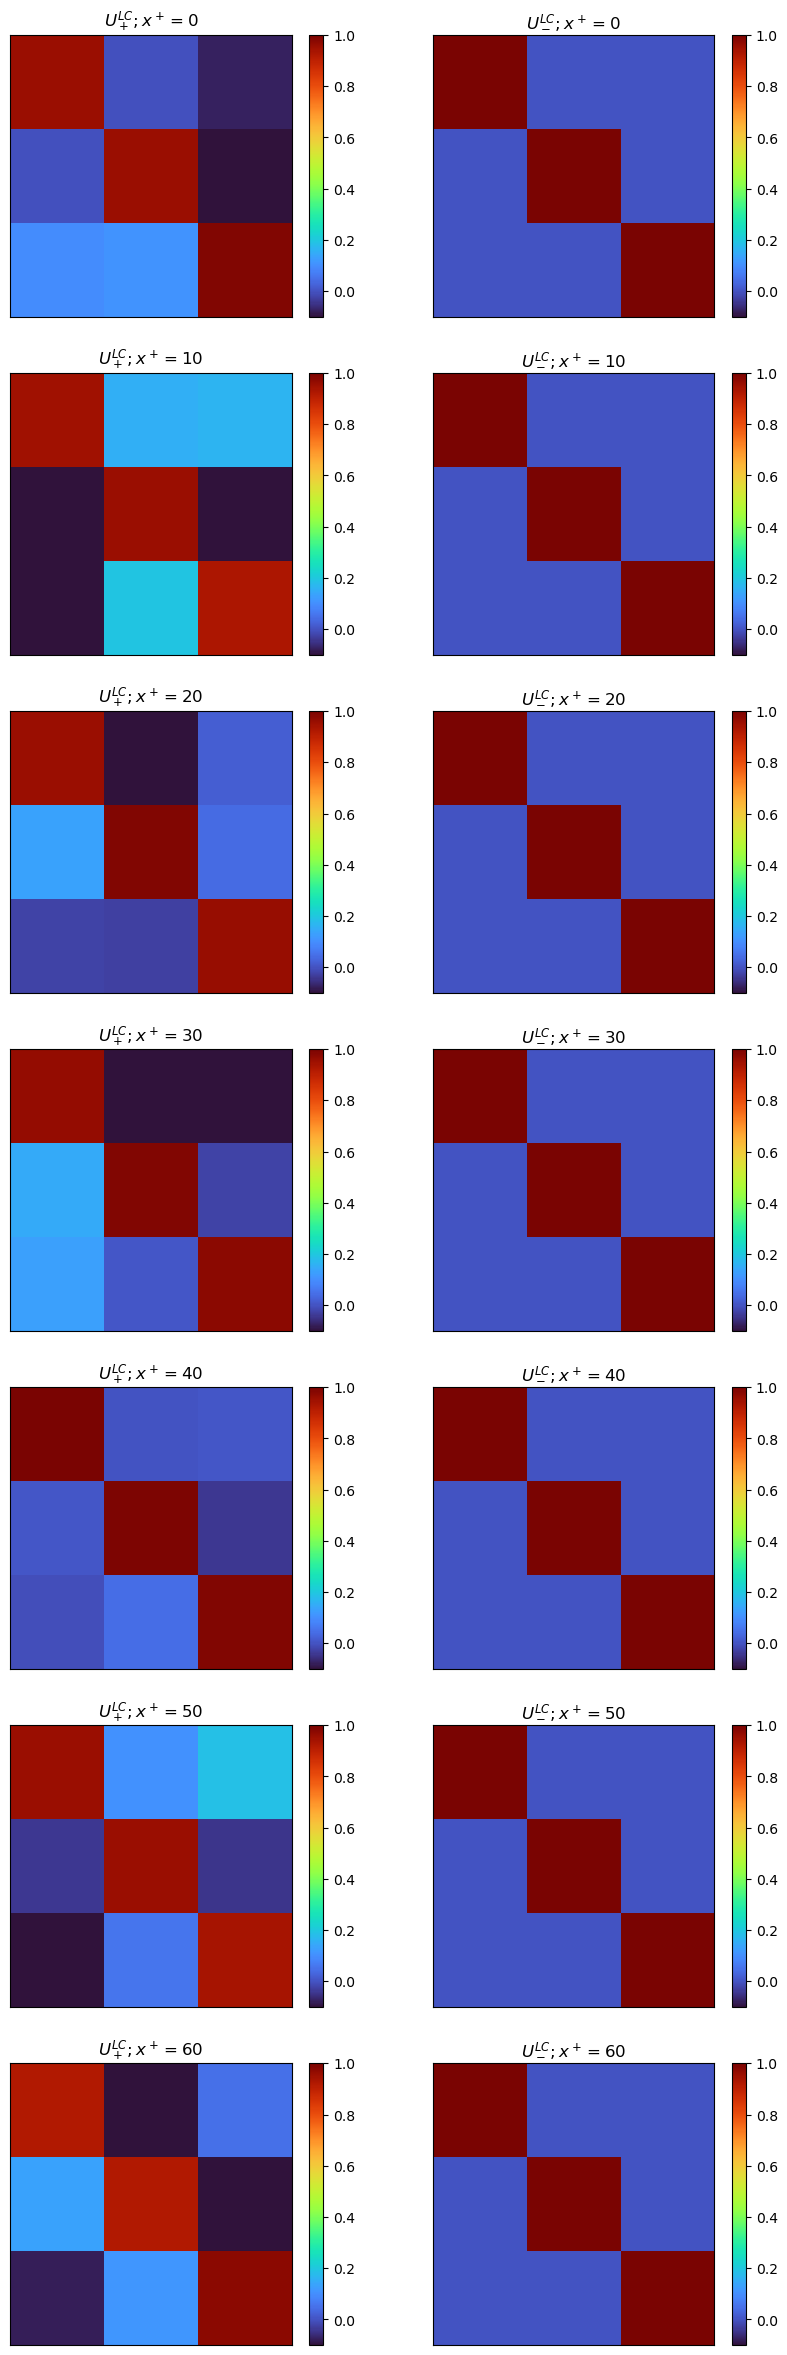

In [ ]:
import matplotlib.pyplot as plt 

y = N//2; z = N//2

fig, axs = plt.subplots(t_steps//10 +1, 3, figsize=(15,30))

for t in range(t_steps//10 + 1): 
    tau = 10*t
    
    plot1 = axs[t,0].imshow(uplus_LC_r[tau, y, z, :, :].real, cmap='turbo', vmin=-0.1, vmax=1) 
    axs[t,0].set_title(r'$U_+^{LC}; z=0; x^+ = %i $' %tau)
    plt.colorbar(plot1, ax = axs[t,0])
    axs[t,0].axes.get_xaxis().set_visible(False)
    axs[t,0].axes.get_yaxis().set_visible(False)
    
    plot2 = axs[t,1].imshow(uplus_LC_r[tau, y, 0, :, :].real, cmap='turbo', vmin=-0.1, vmax=1) 
    axs[t,1].set_title(r'$U_+^{LC}; z=-L/2; x^+ = %i $' %tau)
    plt.colorbar(plot1, ax = axs[t,1])
    axs[t,1].axes.get_xaxis().set_visible(False)
    axs[t,1].axes.get_yaxis().set_visible(False)
    
    plot3 = axs[t, 2].imshow(uminus_LC_r[tau, y, z, :, :].real, cmap='turbo', vmin=-0.1, vmax=1)
    axs[t,2].set_title(r'$U_-^{LC}; x^+ = %i $' %tau)
    plt.colorbar(plot3, ax = axs[t,2])
    axs[t,2].axes.get_xaxis().set_visible(False)
    axs[t,2].axes.get_yaxis().set_visible(False)

In [ ]:
for t in range (t_steps//10):

    n = su.tr(np.array(su.mul(u_plus_temp[10*t, N//2, :], su.dagger(uplus_LC[10*t, N//2, :]))) - su.unit())
    d = su.sq(u_plus_temp[10*t, N//2, :] - su.unit())

    r = n/d
    print(r)
# plt.imshow(p.real, cmap='turbo', vmin=-0.1, vmax=1) 


/home2/carlos.lamas/condacurraun/lib/python3.10/site-packages/numba/core/typed_passes.py:329: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.readthedocs.io/en/stable/user/parallel.html#diagnostics for help.

File "../curraun/su3.py", line 416:
@myjit
def dagger(a):
^

  warnings.warn(errors.NumbaPerformanceWarning(msg,
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/lustre/HQCD/carlos.lamas/curraun/curraun/su3.py:460: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "sq" failed type inference due to: No implementation of function Function(<built-in function iadd>) found for signature:
 
 >>> iadd(float64, array(float64, 2d, C))
 
There are 16 candidate implementations:
  - Of which 14 did not match due to:
  Overload of functio

[[ 1.42226024e+02+12.2314761j   2.12280150e+00 -2.18985028j
   8.87825597e-01 +0.07042107j ...  1.14067471e+00 -0.17547594j
  -4.76249704e-02 -1.03390546j  1.24390535e+02+10.20470349j]
 [ 1.42228471e+02+12.23146181j  2.12321635e+00 -2.19022188j
   8.87674638e-01 +0.07044964j ...  1.14087340e+00 -0.17544563j
  -4.76043372e-02 -1.03406811j  1.24392278e+02+10.20466556j]
 [ 1.42230914e+02+12.23144722j  2.12363114e+00 -2.19059343j
   8.87523713e-01 +0.07047818j ...  1.14107213e+00 -0.17541529j
  -4.75836884e-02 -1.03423081j  1.24394022e+02+10.20462762j]
 ...
 [ 1.42505395e+02+12.22737017j  2.17419673e+00 -2.23580497j
   8.69220566e-01 +0.0737936j  ...  1.16587180e+00 -0.17141211j
  -4.49206235e-02 -1.0545269j   1.24608687e+02+10.19992496j]
 [ 1.42507414e+02+12.22731836j  2.17460395e+00 -2.2361684j
   8.69073877e-01 +0.07381902j ...  1.16607632e+00 -0.17137729j
  -4.48979414e-02 -1.05469423j  1.24610434e+02+10.19988643j]
 [ 1.42509428e+02+12.22726624j  2.17501111e+00 -2.23653176j
   8.689272